IMPORTS

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset

DATASET CIFAR10

In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

IMG_SIZE = 224
train_tf = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])
val_tf   = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])

train_full = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=train_tf)

idx = np.arange(len(train_full))
val_idx = idx[-5000:]
tr_idx  = idx[:-5000]

train_ds = Subset(train_full, tr_idx)
val_ds   = Subset(train_full, val_idx)

class_names = train_full.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Train:", len(train_ds), "Val:", len(val_ds))


100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train: 45000 Val: 5000


IMAGE

In [5]:
def show_image(img_tensor, title=""):
    img = img_tensor.permute(1,2,0).numpy()
    IMG_SIZE = 224
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


**PIPELINE A** KEYPOINTS AND DESCRIPTORS EXTRACTION

In [6]:
orb = cv2.ORB_create(
    nfeatures=1000
)
def orb_descriptors_from_tensor(img_tensor):

    img = (img_tensor.permute(1,2,0).numpy() * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return descriptors


In [7]:
def build_vocabulary(train_ds, max_images=5000, max_desc_total=200000, K=400):
    all_desc = []
    collected = 0

    for i in tqdm(range(min(len(train_ds), max_images)), desc="Collecting ORB descriptors"):
        img, _ = train_ds[i]
        desc = orb_descriptors_from_tensor(img)

        if desc is not None:
            all_desc.append(desc)
            collected += desc.shape[0]

        if collected >= max_desc_total:
            break

    all_desc = np.vstack(all_desc)

    print("Total descriptors collected:", all_desc.shape[0])

    kmeans = MiniBatchKMeans(n_clusters=K, random_state=SEED, batch_size=4096)
    kmeans.fit(all_desc)

    return kmeans


In [ ]:
BoVW HISTOGRAM

In [8]:
def bovw_histogram(img_tensor, kmeans, K):
    desc = orb_descriptors_from_tensor(img_tensor)

    hist = np.zeros(K, dtype=np.float32)

    if desc is None:
        return hist
    words = kmeans.predict(desc)


    for w in words:
        hist[w] += 1.0


    hist = hist / (hist.sum() + 1e-8)
    return hist


TRANING FEATURE MATRIX (X,y)

In [9]:
def dataset_to_bovw_xy(ds, kmeans, K, max_samples=5000):
    X, y = [], []
    n = min(len(ds), max_samples)

    for i in tqdm(range(n), desc="Building BoVW features"):
        img, label = ds[i]
        hist = bovw_histogram(img, kmeans, K)
        X.append(hist)
        y.append(label)

    return np.stack(X), np.array(y)


TRAIN KNN

In [10]:
K = 200
kmeans = build_vocabulary(train_ds, max_images=5000, K=K)

X_train, y_train = dataset_to_bovw_xy(train_ds, kmeans, K, max_samples=10000)
X_val, y_val     = dataset_to_bovw_xy(val_ds, kmeans, K, max_samples=2000)

knn = KNeighborsClassifier(
    n_neighbors=5,
    metric="euclidean"
)
knn.fit(X_train, y_train)

preds = knn.predict(X_val)
acc = accuracy_score(y_val, preds)

print("Pipeline A (ORB + BoVW + kNN) accuracy:", acc)


Total descriptors collected: 164129


Building BoVW features: 100%|██████████| 2000/2000 [00:05<00:00, 344.10it/s]


Pipeline A (ORB + BoVW + kNN) accuracy: 0.1415


CONFUSION MATRIX

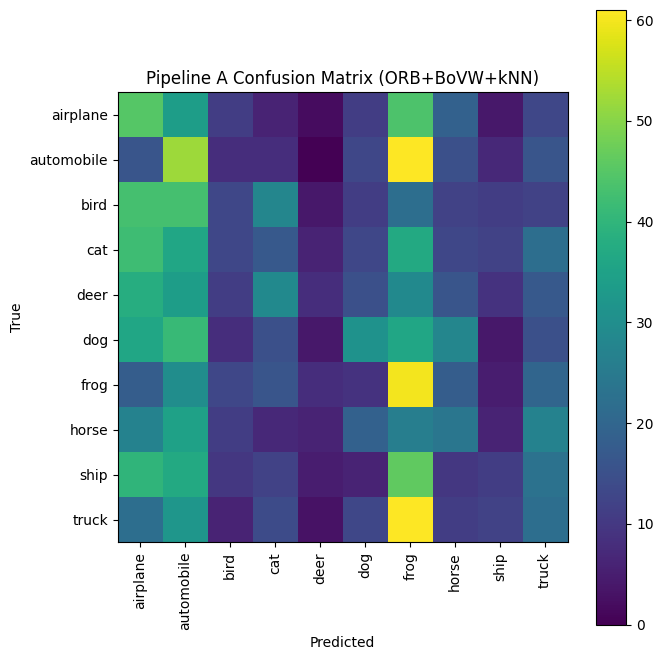

In [11]:
cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(7,7))
plt.imshow(cm)
plt.title("Pipeline A Confusion Matrix (ORB+BoVW+kNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), class_names, rotation=90)
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


**PIPELINE B CNN** BUILD CNN

In [12]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_full.classes
num_classes = len(class_names)

print("OK: train_loader and val_loader created")
print("Train size:", len(train_ds), "Val size:", len(val_ds))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s]


OK: train_loader and val_loader created
Train size: 45000 Val size: 5000


TRAINING

In [13]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    all_preds, all_y = [], []
    for x, y in tqdm(loader):
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_y.append(y.numpy())
    return np.concatenate(all_y), np.concatenate(all_preds)


TRAIN FOR SOME EPOCHS

In [14]:
EPOCHS = 3

for epoch in range(EPOCHS):
    loss = train_one_epoch(model, train_loader)
    y_true_b, preds_b = eval_model(model, val_loader)
    acc_b = accuracy_score(y_true_b, preds_b)
    print(f"Epoch {epoch+1}/{EPOCHS} | loss={loss:.4f} | val_acc={acc_b:.4f}")


100%|██████████| 157/157 [00:08<00:00, 19.24it/s]


Epoch 1/3 | loss=0.5398 | val_acc=0.8606


100%|██████████| 157/157 [00:08<00:00, 18.43it/s]


Epoch 2/3 | loss=0.3411 | val_acc=0.8764


100%|██████████| 157/157 [00:08<00:00, 18.26it/s]

Epoch 3/3 | loss=0.2764 | val_acc=0.9056


CONFUSION MATRIX

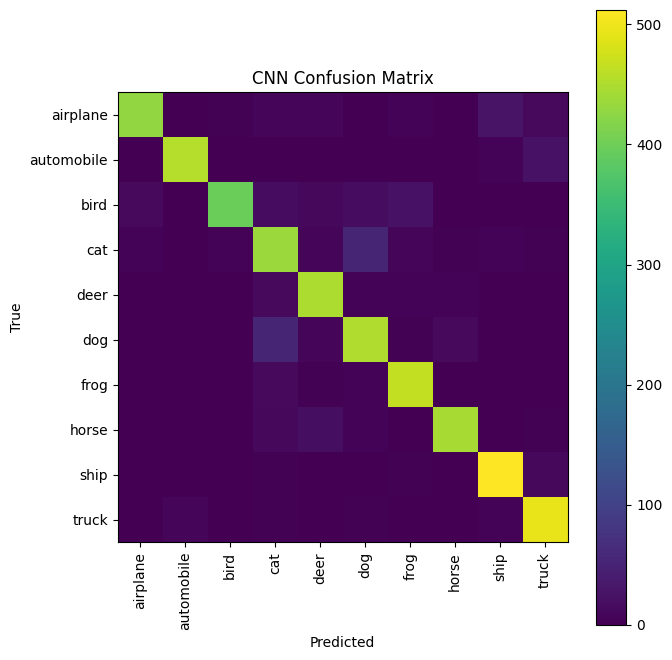

In [15]:
cm = confusion_matrix(y_true_b, preds_b)

plt.figure(figsize=(7,7))
plt.imshow(cm)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), class_names, rotation=90)
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()
